# Pattern Recognition 1 - Expert System

**Objectives**

* Create a working image analysis and pattern recognition pipeline
* Object labelisation and feature extraction
* Creating an Expert System for Optical Character Recognition (OCR)

**Libraries needed for this lab**

* Numpy
* Matplotlib
* Scikit-image

(all included in the Anaconda distribution)

## Object detection

Given the following image :

(851, 1068) uint8


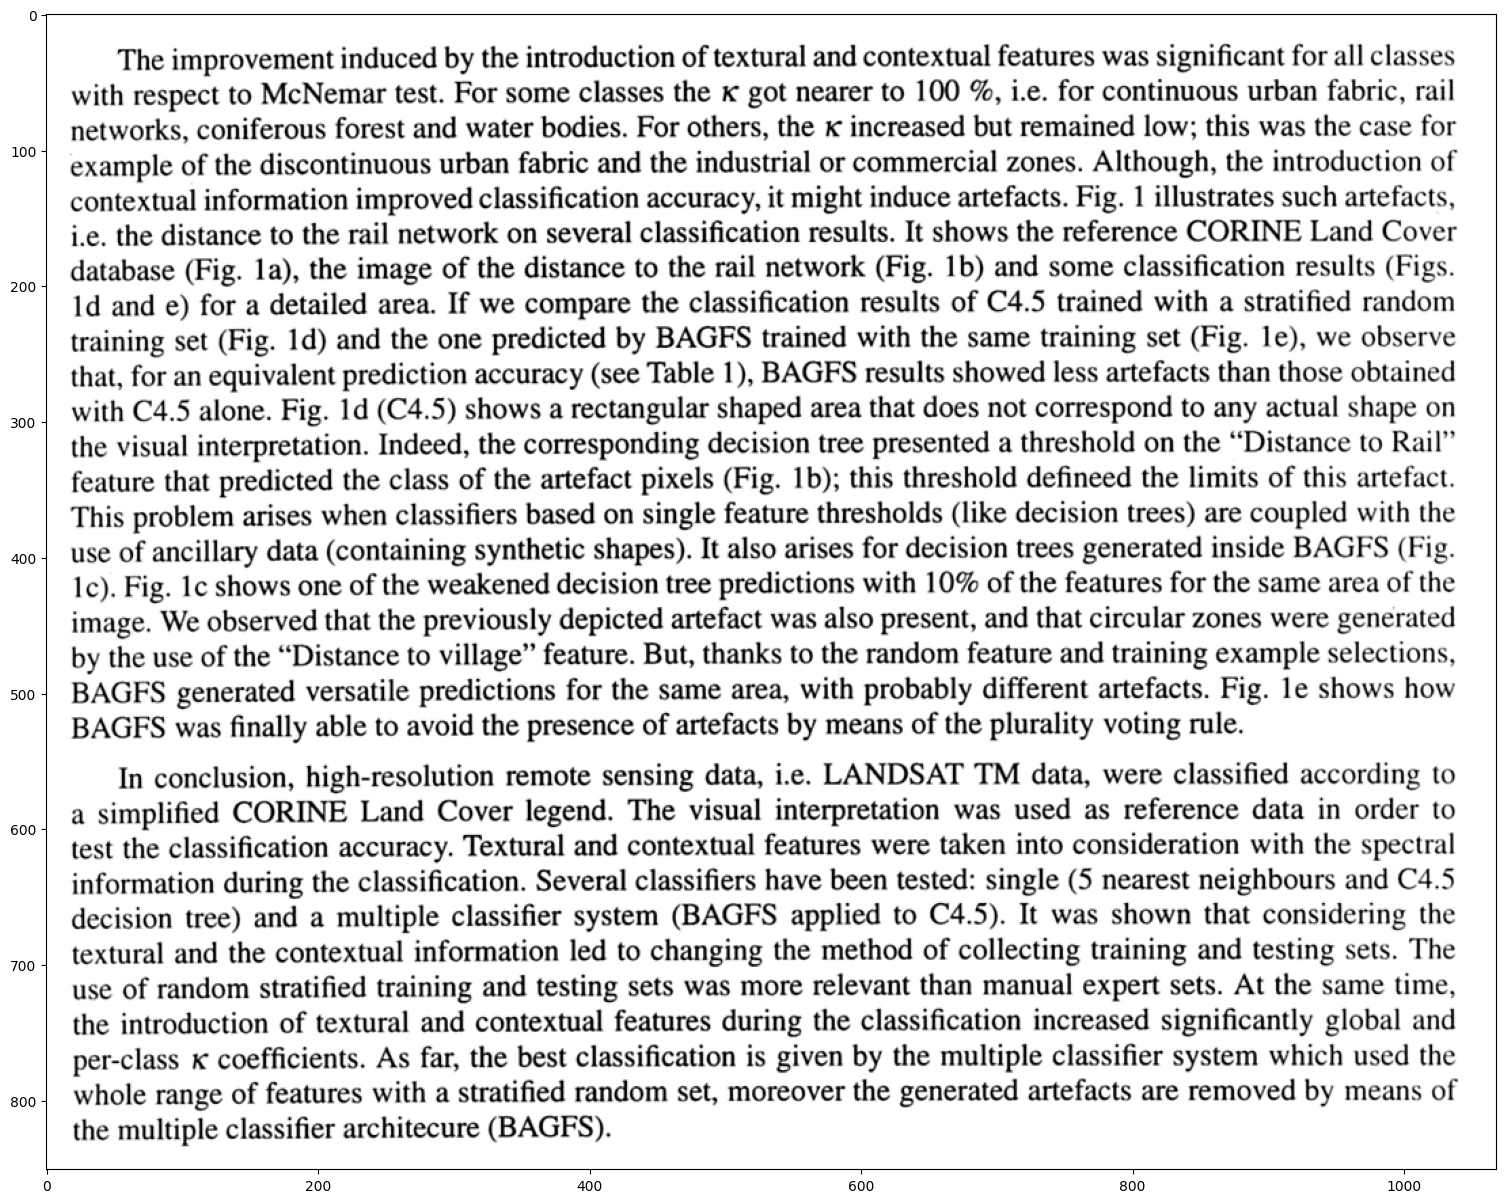

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
# %matplotlib inline

im = imread('../data/doc1.png')
print(im.shape, im.dtype)

plt.figure(figsize=(20,15))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

* **Segment** the image to isolate the text from the background
* **Label individual characters** and **extract** the centroid position, the bounding box, and useful features for each character.

Useful documentation: [`skimage.measure`](http://scikit-image.org/docs/dev/api/skimage.measure.html) module.

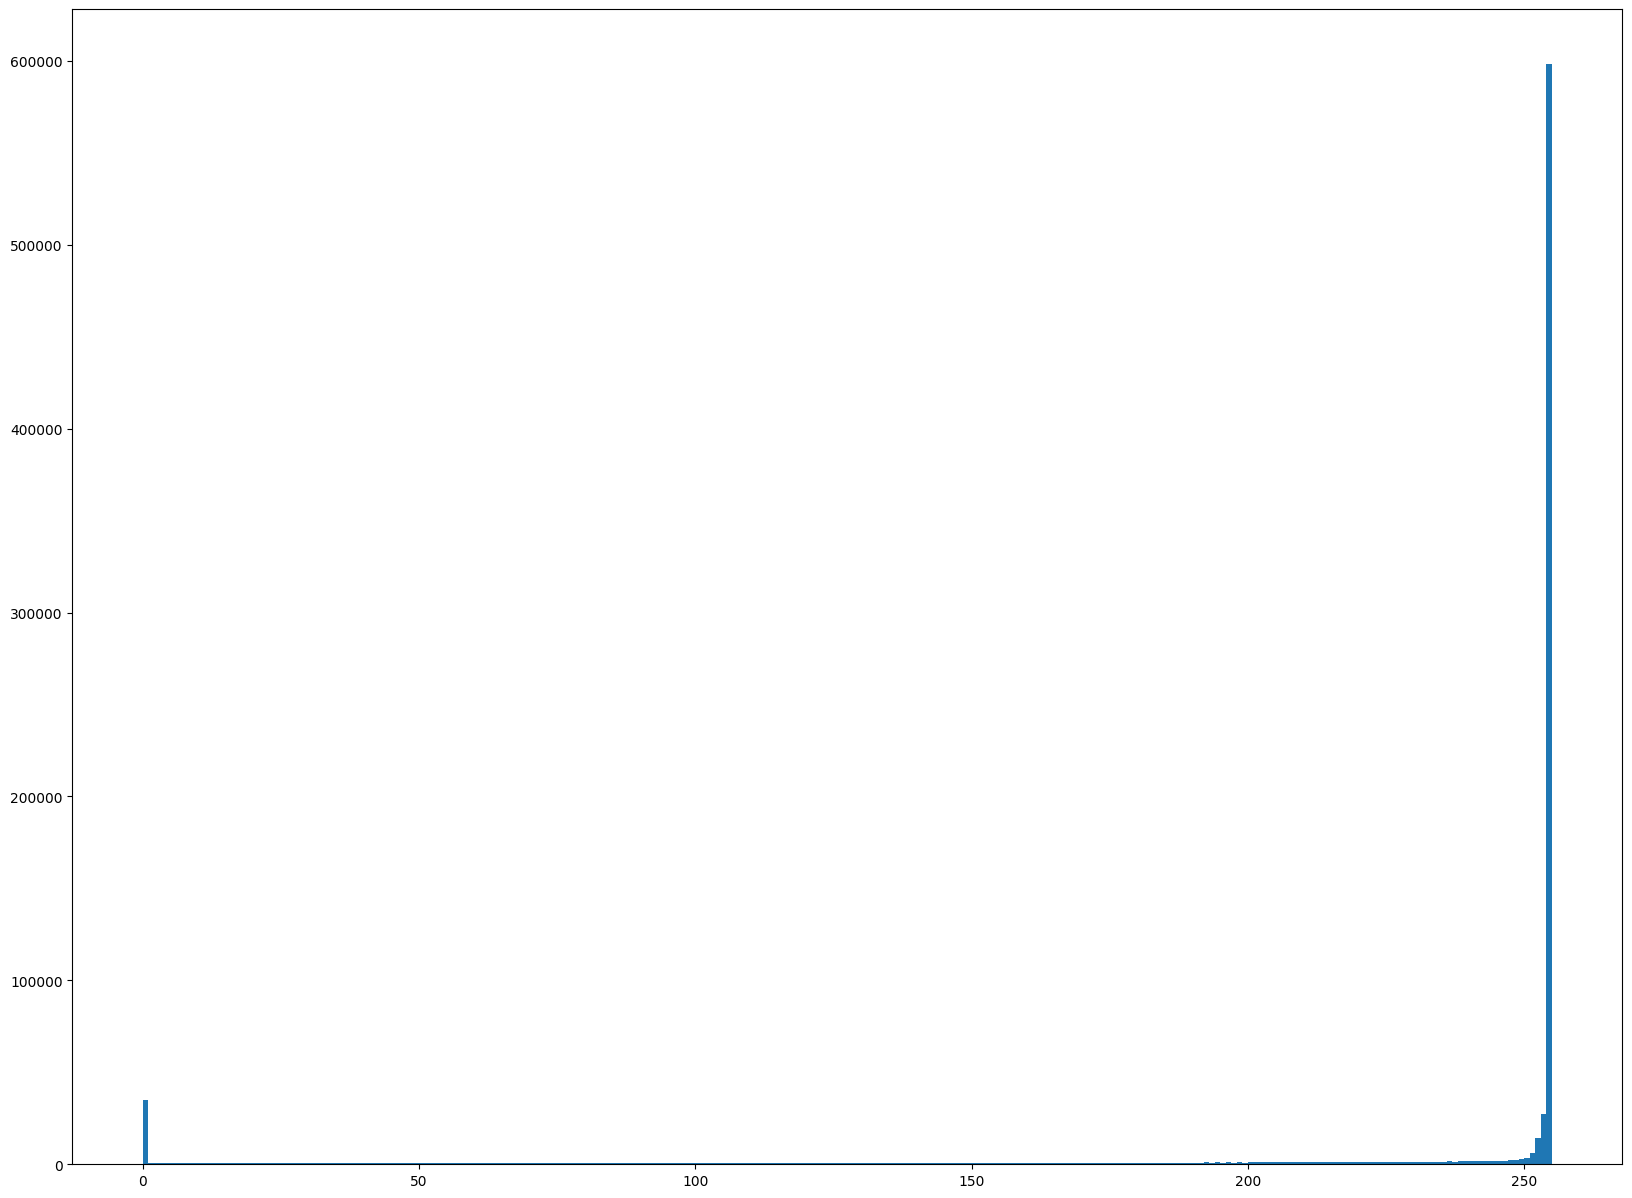

Threshold: 154


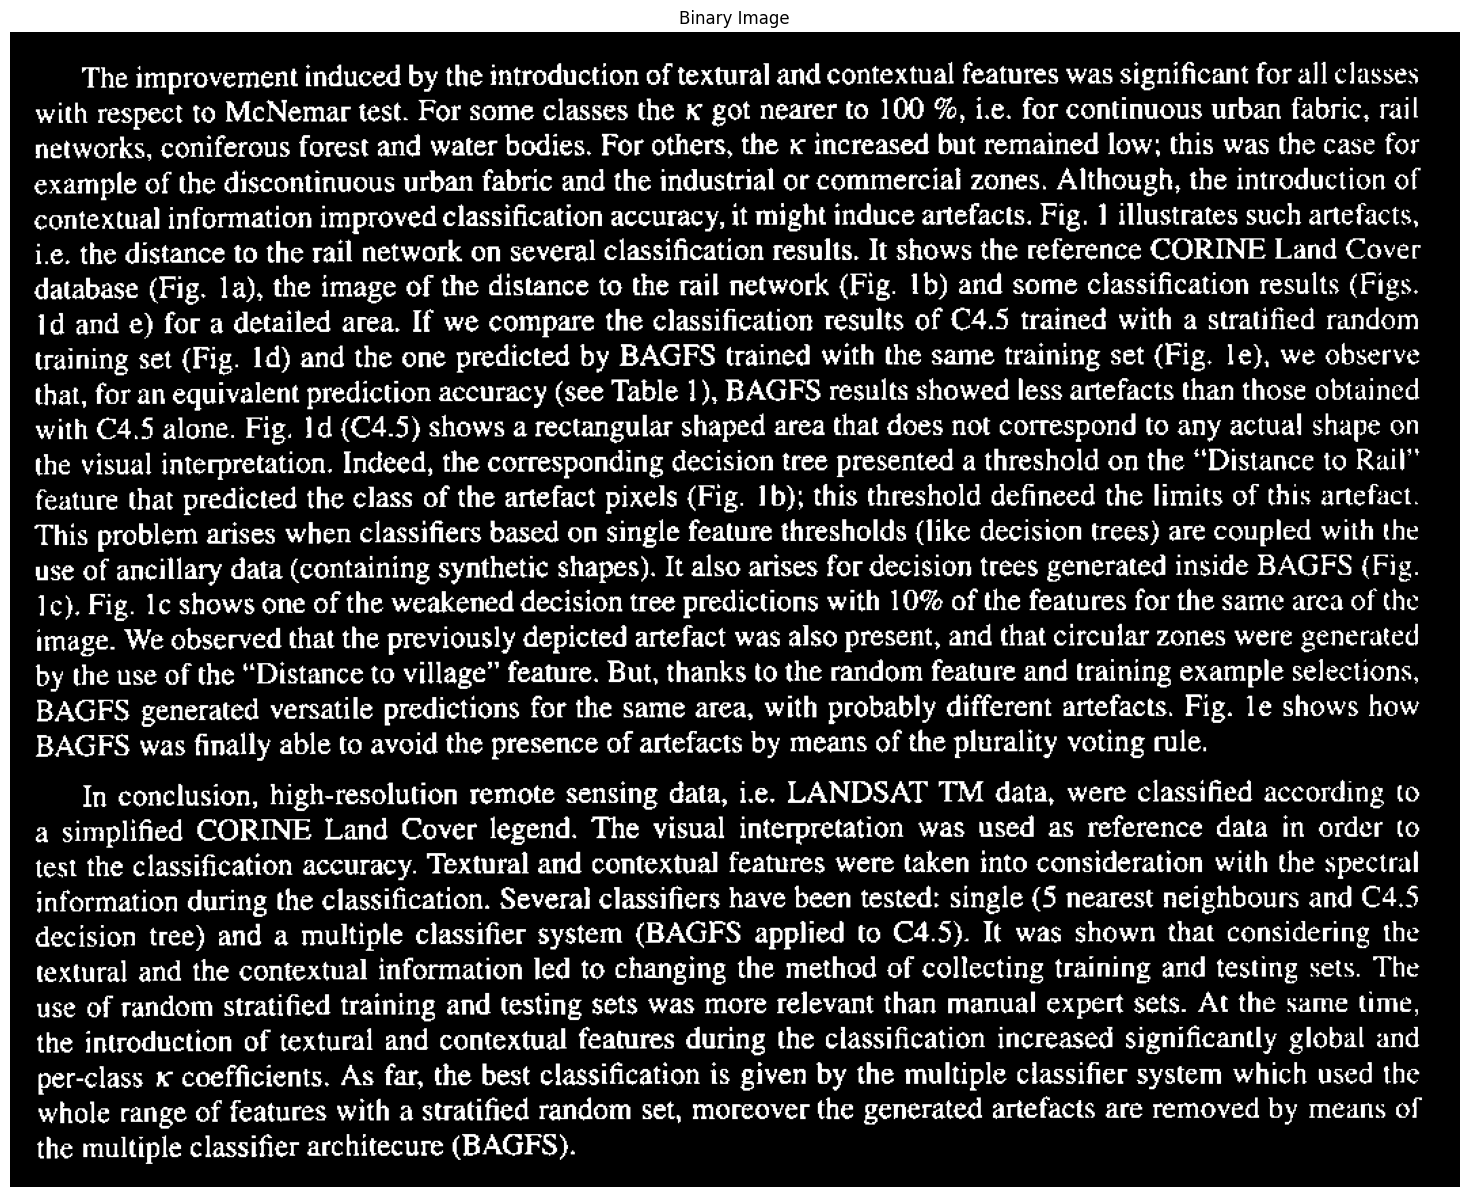

In [7]:
# segment the image to isolate the text
from skimage.filters import threshold_otsu
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.measure import label, regionprops

im = imread('../data/doc1.png')
#plot the histogram
plt.figure(figsize=(20,15))
plt.hist(im.flatten(), bins=255)
plt.show()
# calculate the threshold
thresh = threshold_otsu(im) # a bit overkill, but it works
print('Threshold:', thresh) #154
binary = im < thresh # return true for pixels above the threshold
plt.figure(figsize=(20,15))
plt.title('Binary Image')
plt.imshow(binary, cmap=plt.cm.gray)
plt.axis('off')
plt.show()


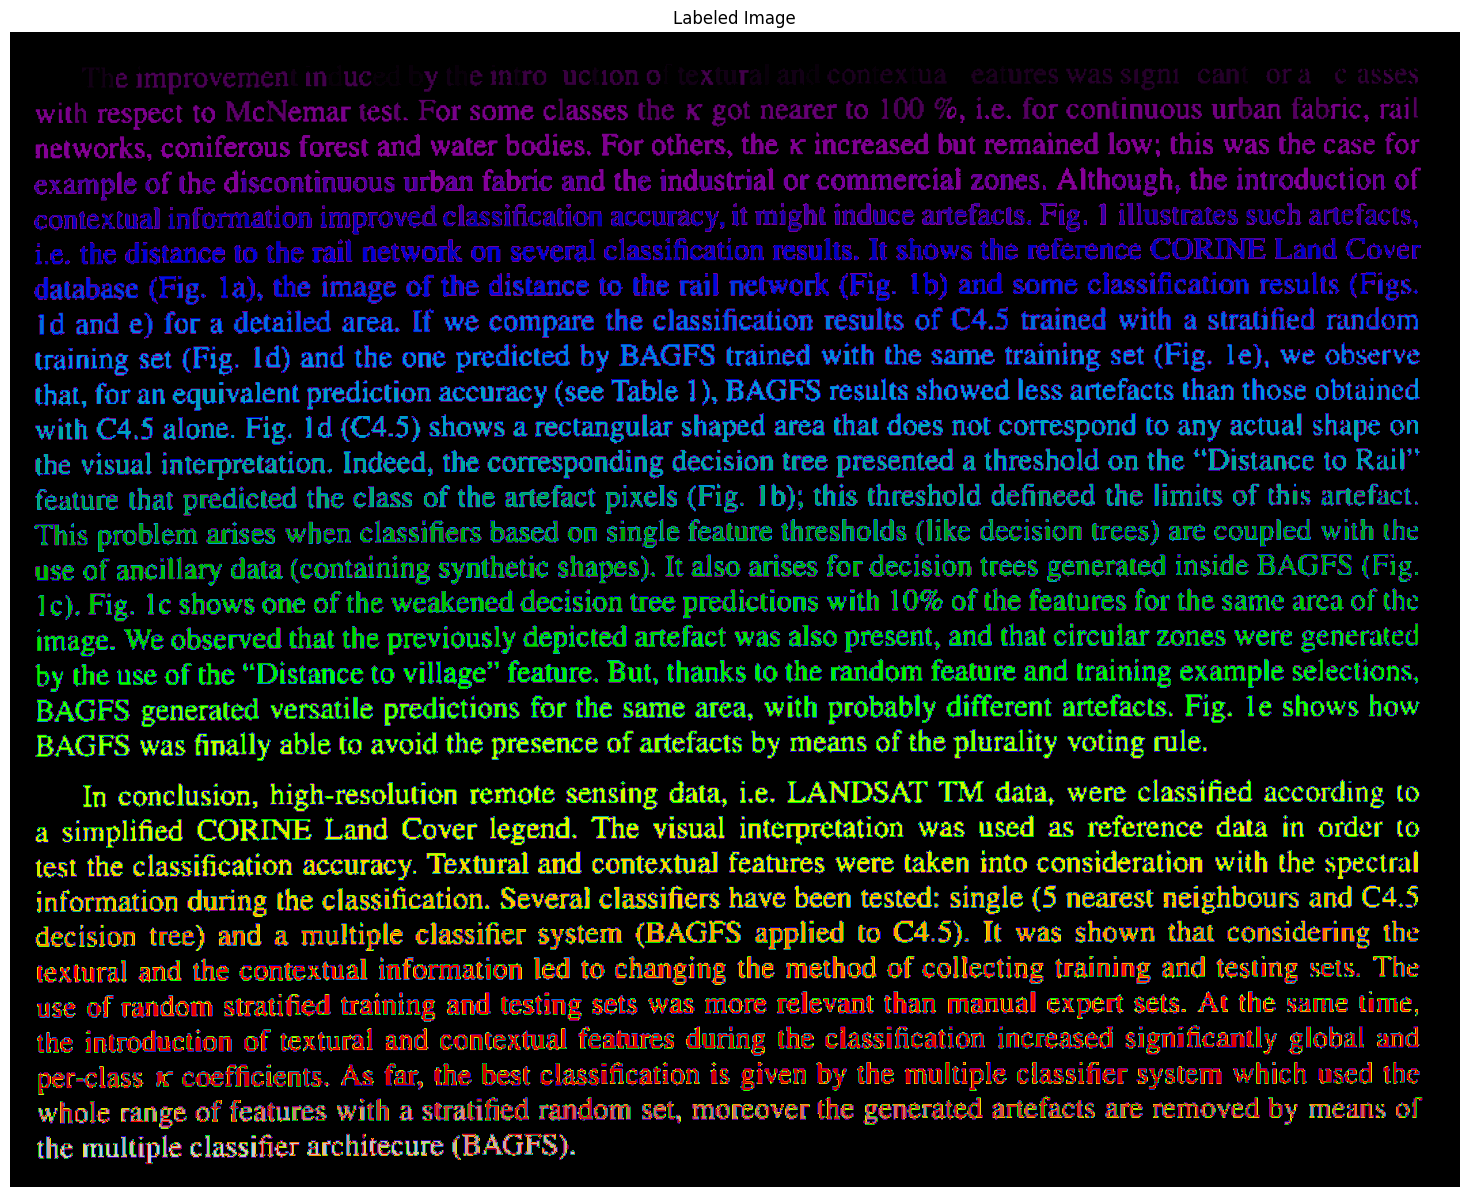

Number of characters: 3011


In [8]:

# label individual characters
label_image = label(binary,background=0, connectivity=2) #the background is 1 because the image is binary
plt.figure(figsize=(20,15))
plt.title('Labeled Image')
plt.imshow(label_image, cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()

regions = regionprops(label_image)
print('Number of characters:', len(regions))


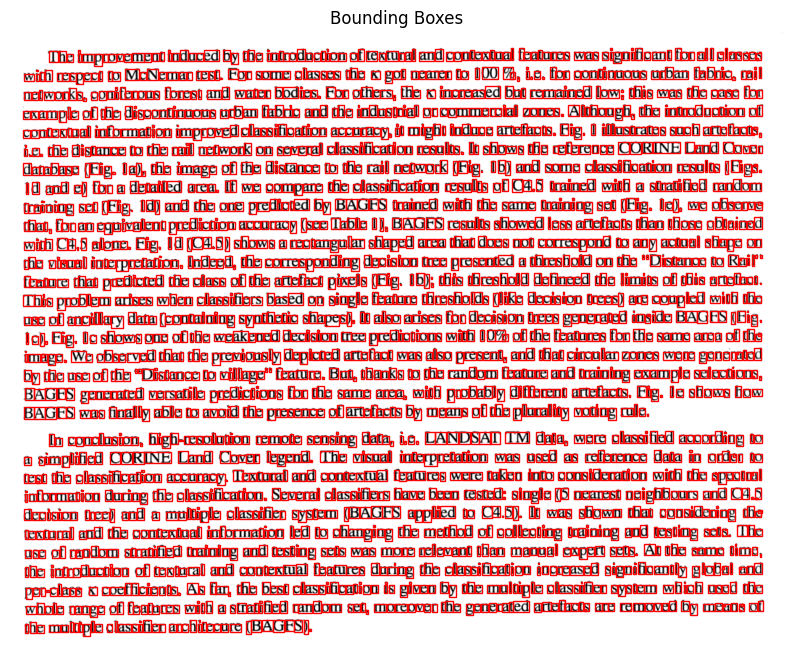

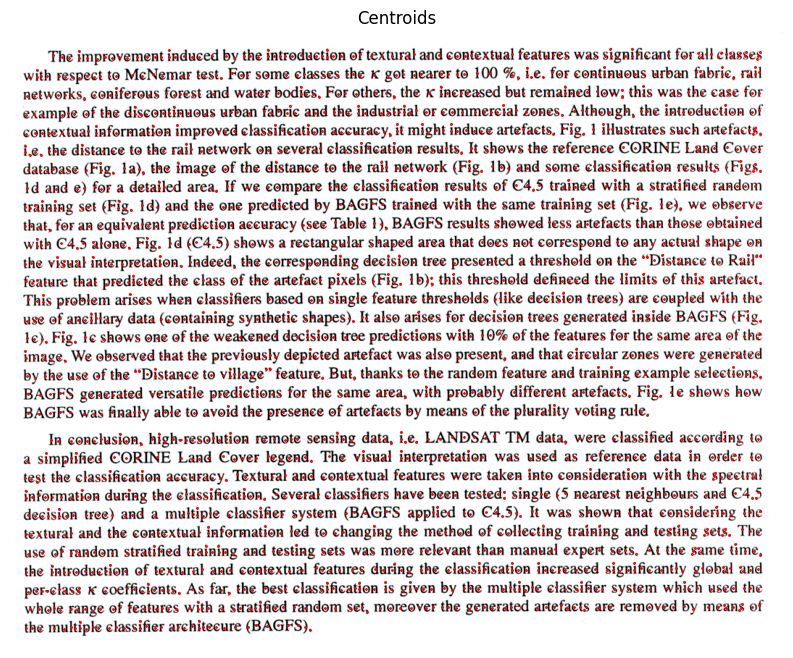

In [9]:

#for each labeled region, draw the bounding boxes on the same image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(im, cmap='gray')
for region in regions:
    # draw rectangle around segmented character
    minr, minc, maxr, maxc = region.bbox
    rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
                        fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    plt.axis('off')
plt.title('Bounding Boxes')
plt.show()

# draw centroids on the image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(im, cmap='gray')
for region in regions:
    # draw centroid
    y0, x0 = region.centroid
    ax.plot(x0, y0, 'ro', markersize=1)
plt.title('Centroids')
plt.axis('off')
plt.show()


## Line detection and letter ordering

* Find the labels (objects) that belong to each text line
* Order each character in a text line from left to right

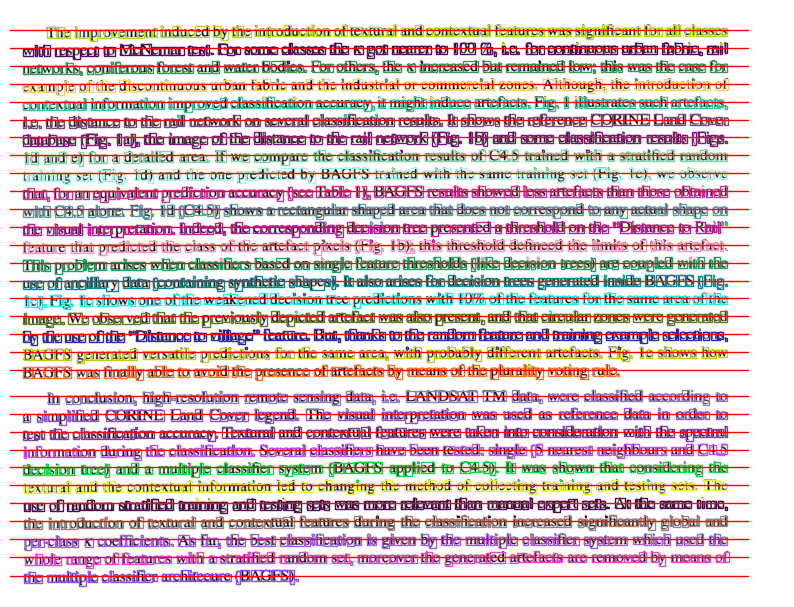

In [10]:
#find labels that belongs to each text line
from skimage.measure import regionprops
from skimage.measure import label
from skimage.filters import threshold_otsu
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
from collections import defaultdict

def group_lines_by_labels(regions, threshold=10):
    """
    Group labels that belong to the same text line based on vertical proximity.
    
    Args:
        regions: List of region properties from skimage.measure.regionprops.
        threshold: Maximum vertical distance between bounding boxes to consider them in the same line.
    
    Returns:
        A list of lists, where each inner list contains the bounding boxes of a single text line.
    """
    lines = defaultdict(list) #used to have an empty list for each line even if the key is not present

    for region in regions:
        minr, minc, maxr, maxc = region.bbox
        # Find the center of the bounding box (can use the centroid as well)
        center_y = (minr + maxr) // 2

        # Assign the region to the closest line based on vertical proximity
        assigned = False
        for line_center in lines:
            if abs(center_y - line_center) <= threshold:
                lines[line_center].append((minr, minc, maxr, maxc))
                assigned = True
                break

        # If no line is close enough, create a new line
        if not assigned:
            lines[center_y].append((minr, minc, maxr, maxc))

    # Return the grouped lines as a list of lists
    return list(lines.values()),list(lines.keys())

def find_lines(im, threshold=15):
    # Segment the image to isolate the text
    thresh = threshold_otsu(im)
    binary = im > thresh

    # Label individual characters
    label_image = label(binary, background=1, connectivity=2)

    # Find regions
    regions = regionprops(label_image)

    # Group labels into text lines
    textline,lines = group_lines_by_labels(regions, threshold)

    return textline,lines

def draw_lines(im, textline, lines):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(im, cmap='gray')
    for line in textline:
        color = (random.random(), random.random(), random.random())
        for bbox in line:
            minr, minc, maxr, maxc = bbox
            rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor=color, linewidth=1)
            ax.add_patch(rect)
    for line in lines:
        y0 = line
        ax.plot([0, im.shape[1]], [y0, y0], 'r-', linewidth=1)
    plt.axis('off')
    plt.show()

im = imread('../data/doc1.png')
textline, lines = find_lines(im, threshold=20)  # Adjust threshold as needed
draw_lines(im, textline, lines)


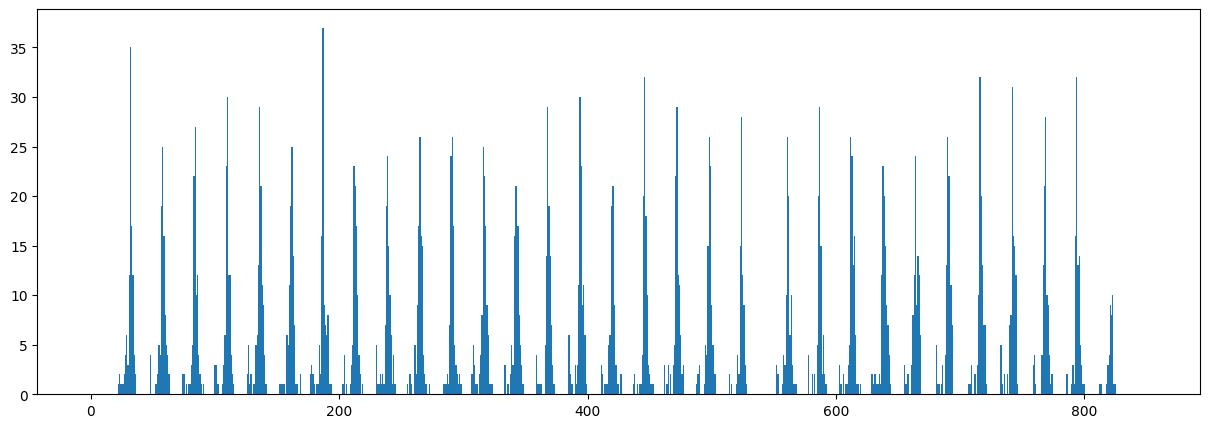

In [11]:
# from the correction
centroid_ys = np.zeros((im.shape[0]))
for region in regions:
    centroid_ys[int(region['centroid'][0])] += 1 #every time there is a centroid, add 1 to the corresponding y coordinate

plt.figure(figsize=(15,5))
plt.bar(range(im.shape[0]), centroid_ys, width=1)
plt.show()

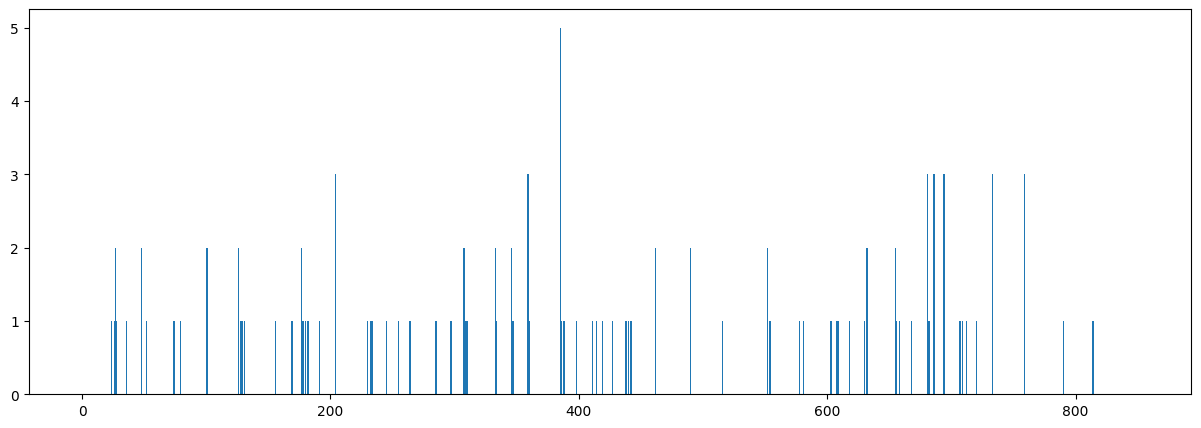

In [12]:
# from the correction
centroid_ys = np.zeros((im.shape[0]))
for region in regions:
    if region.area < 5:
        centroid_ys[int(region['centroid'][0])] += 1 #every time there is a centroid, add 1 to the corresponding y coordinate

plt.figure(figsize=(15,5))
plt.bar(range(im.shape[0]), centroid_ys, width=1)
plt.show()

## Expert System classification

* Using the features available with the [regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) method of scikit-image, propose a method to automatically recognize some letters.

Let's try some rules. One descriptor that we can use is the euler number, defined as $N_{objects}-N_{holes}$, which as we are always looking at one object is equivalent to $1-N_{holes}$. Most letters will have an euler number of 0 (1hole : a,b,d,...) or 1 (No hole : C,f,h,...). With only a few letters having a euler number below 0 (2 holes : g,B).

The first rule might be :
- If euler number == -1
    - if the centroid of the letter is below the center of the line by large margin enough it's a g
    - if the bounding box is not too large : it's a B
- Else : it's a double letter that should be removed

By using this kind of apporoach, we can find other letters. A more robust way of doing this is using machine learning.

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
from skimage.transform import resize

def recognize_letters(regions, templates):
    """
    Test
    """
    recognized_letters = []

    for region in regions:
        char_image = region.image  # Binary image of the character
        best_match = None
        best_score = -1

        for letter, template in templates.items():
            # Resize the character to match the template size
            char_resized = resize(char_image, template.shape, anti_aliasing=True)
            char_resized = char_resized > 0.5  # Ensure binary

            # Compute similarity score
            score = ssim(char_resized, template)

            if score > best_score:
                best_score = score
                best_match = letter

        recognized_letters.append(best_match)

    return recognized_letters

from skimage.transform import resize

# After finding regions
regions = regionprops(label_image)

# correction
plt.figure()
plt.imshow(im, cmap='gray')
for idline, line in enumerate(recognize_letters):
    for idletter in line:
        


NameError: name 'recognized_letters' is not defined

## Full OCR pipeline

Using all the previous exercices, create a method that takes as input a text image, and outputs the recognized text.

In [ ]:
def OCR(im):
    text = ''
    
    return text

print(OCR(im))